## Comparison between next token prediction (NTP) and multi-token prediction (MTP)

Let true dist $p$ satisfy 
$$p(y_1| x) = \sigma(W_a x)$$
$$p(y_1, y_2| x) = \sigma(W_a x) \sigma(W_a x)^\top$$ 

We then compare fitting $\widehat{W}_a$ using two either of the two objectives:

- $l^{(ntp)}(\theta) = \sum_{x,y_1} -\log \sigma(\widehat{W}_a x)$ 
- $l^{(mtp)}(\theta) =  \sum_{x,y_1, y_2} -\log \sigma(\widehat{W}_a x)_{y_1}  + -\log \sigma(\widehat{W}_a x)_{y_1} \sigma(\widehat{W}_a x)_{y_2}$

### Define true model

In [1]:
import torch
from typing import Optional
from dataclasses import dataclass
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class TrueModel:
    def __init__(self, d_model, d_vocab, rank=1):
        super().__init__()
        self.d_model = d_model
        self.d_vocab = d_vocab
        if rank == 1:
            self.w_alpha = torch.zeros(d_vocab, d_model)
            self.w_alpha[0] = 1
        elif rank == 2:
            self.w_alpha = torch.zeros(d_vocab, d_model)
            self.w_alpha[0] = 1
            self.w_alpha[1] = 1
        elif rank == 4:
            self.w_alpha = torch.zeros(d_vocab, d_model)
            self.w_alpha[0] = 1
            self.w_alpha[1] = 1
            self.w_alpha[2] = 1
            self.w_alpha[3] = 1
        else:
            raise ValueError(f"Rank {rank} not supported")

    def get_xy_samples(self, n_samples=1, horizon=1):
        """Sample x, y from p(x) and p(x,y1, y2, ..., yH | x)

        Args:
            n_samples (int, optional): Number of samples to draw from p(x). Defaults to 1.
            horizon (int, optional): Number of samples to draw from p(y1, y2, ..., yH | x). Defaults to 1.

        Returns:
            x: (n_samples, d_model)
            y: (n_samples, horizon)
        """
        x = torch.randn(n_samples, self.d_model)
        py_h_bar_x = torch.softmax(torch.einsum('bd, vd->bv', x, self.w_alpha), dim=-1)
        y = torch.cat([torch.multinomial(py_h_bar_x, num_samples=1) for _ in range(horizon)], dim=-1)
        return x, y

In [3]:
# Set seed
torch.manual_seed(42)

# HPs
lr = 1e-3
batch_size = 32
n_epochs = 50_000
eval_every = 1000
d_model, d_vocab = 32, 32

In [4]:
from mtp.mheads import MHEADS
from mtp.mheads._abc import AbstractDisributionHeadConfig

@dataclass
class ModelOutput:
  logits: torch.Tensor
  loss: Optional[torch.Tensor] = None
  loss_dict: Optional[dict] = None


class MTModel(torch.nn.Module):
  def __init__(self, d_model, d_vocab, lam=0.0, mt_head=None, mt_horizon=1, mt_rank=1):
    super().__init__()
    self.w_alpha_hat = torch.nn.Linear(d_model, d_vocab, bias=False)
    self.lam = lam
    self.mt_head = mt_head
    self.mt_horizon = mt_horizon
    self.mt_rank = mt_rank
    if mt_head is not None:
      self.mt_head = MHEADS[mt_head](
          config=AbstractDisributionHeadConfig(
            d_model=d_model, 
            d_output=d_vocab, 
            horizon=mt_horizon, 
            rank=mt_rank
          )
      )

  def set_w_alpha(self, w_alpha):
    self.w_alpha_hat.weight.data = w_alpha.clone().detach()
    if self.mt_head is not None and hasattr(self.mt_head, 'set_decoder'):
      print(f"Setting decoder for {self.mt_head}")
      self.mt_head.set_decoder(w_alpha)

  def forward(self, x, y=None):
    """
      Args:
        x: Input features. Shape: (B, D)
        y: Targets. Shape (B, H)
    """
    loss = None
    loss_main = 0
    loss_aux = 0
    logits = self.w_alpha_hat(x) # B,D -> B,V
    loss_dict = {}
    if y is not None:
      loss_main = torch.nn.functional.cross_entropy(logits, y[:, 0])
      if self.mt_head is not None:
        output = self.mt_head(x, y)
        loss_aux = output.loss
      loss = loss_main + loss_aux * self.lam
      loss_dict = {'loss_main': loss_main, 'loss_aux': loss_aux}
    return ModelOutput(loss=loss, logits=logits, loss_dict=loss_dict)

/Users/marawangamal/Documents/github/mtl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def run_train(models, batch_size, d_model, d_vocab, n_epochs, eval_every, lr, X=None):

    for m in models:
        # Define an optimizer
        optimizer = optim.AdamW(m['model'].parameters(), lr=lr)

        # Training loop (minimal example)
        for epoch in range(n_epochs): # train for 10 epochs
            optimizer.zero_grad()
            X, y = m['sample_fn'](batch_size)
            output = m['model'](X, y) # Forward pass
            loss = output.loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            if (epoch + 1) % eval_every == 0:
                X, y = m['sample_fn'](1000)
                output = m['model'](X, y) # Forward pass
                acc = torch.softmax(output.logits, dim=-1).argmax(dim=-1) == y.argmax(dim=-1)
                acc = acc.sum() / len(acc)
                m['eval/accuracy'].append(acc.item())
                m['eval/loss'].append(output.loss_dict['loss_main'].item())


    return models

### HPO

In [6]:
# IMPORTANT: This cell runs HPO and can be skipped. Best HPs are:
# [main] LR: 0.001 | Max acc: 0.49
# [aux] LR: 0.001, LAM: 0.1 | Max acc: 0.40

# # HPO:
# for lr in [1e-3, 1e-4, 1e-5]:
#     models = [
#         {
#             "name": "main", 
#             "model": ConditionalModel(d_model, d_vocab), 
#             "sample_fn": lambda x, w: get_samples(x, w, horizon=1), 
#             "eval/accuracy": [],
#             "eval/loss": [],
#         },
#     ]

#     run_train(models[:1], batch_size, d_model, d_vocab, n_epochs, eval_every, lr)
#     print(f"[main] LR: {lr} | Max acc: {max(models[0]['eval/accuracy']):.2f}")

# for lr, lam in itertools.product([1e-3, 1e-4, 1e-5], [0, 0.1, 0.5, 1]):
#     models = [
#         {
#             "name": "aux", 
#             "model": JointModel(d_model, d_vocab, lam=lam),
#             "sample_fn": lambda x, w: get_samples(x, w, horizon=2), 
#             "eval/accuracy": [],
#             "eval/loss": [],
#         }
#     ]
#     run_train(models[:1], batch_size, d_model, d_vocab, n_epochs, eval_every, lr)
#     print(f"[aux] LR: {lr}, LAM: {lam} | Max acc: {max(models[0]['eval/accuracy']):.2f}")


### Train in Infinite Data Setting

In [7]:
# Best HPs:
# [main] LR: 0.001 | Max acc: 0.49
# [aux] LR: 0.001, LAM: 0.1 | Max acc: 0.40

# Target model
gt_model = TrueModel(d_model, d_vocab)

# Models to train
models = [
    {
        "name": "main", 
        "model": MTModel(d_model, d_vocab), 
        "sample_fn": lambda n: gt_model.get_xy_samples(n_samples=n, horizon=1), 
        "eval/accuracy": [],
        "eval/loss": [],
    }
for _ in range(3)] + [
    {
        "name": "aux", 
        "model": MTModel(d_model, d_vocab), 
        "sample_fn": lambda n: gt_model.get_xy_samples(n_samples=n, horizon=2), 
        "eval/accuracy": [],
        "eval/loss": [],
    }
 for _ in range(3)]
# Start from same init for w_alpha_hat
w_alpha_hat = torch.randn(d_vocab, d_model)
for m in models:
    print(f"Setting w_alpha_hat for {m['name']}")
    m['model'].w_alpha_hat.weight.data = w_alpha_hat.clone().detach()
models = run_train(models, batch_size, d_model, d_vocab, n_epochs, eval_every, lr=1e-3)

Setting w_alpha_hat for main
Setting w_alpha_hat for main
Setting w_alpha_hat for main
Setting w_alpha_hat for aux
Setting w_alpha_hat for aux
Setting w_alpha_hat for aux


In [8]:
import pandas as pd


dfs = []
for m in models:
    print(m['name'])
    df_i = pd.DataFrame({'epoch': range(len(m['eval/accuracy'])), 'eval/accuracy': m['eval/accuracy'], 'eval/loss': m['eval/loss'], 'name': m['name']})
    dfs.append(df_i)    
df = pd.concat(dfs)

main
main
main
aux
aux
aux


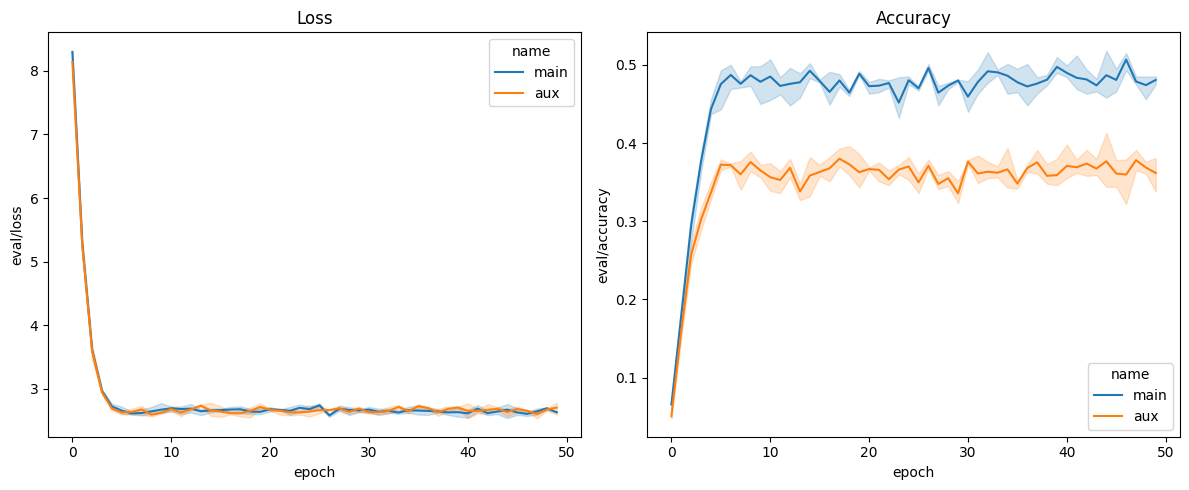

<Figure size 640x480 with 0 Axes>

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.lineplot(data=df, x="epoch", y="eval/loss", hue="name", ax=axes[0])
axes[0].set_title("Loss")

sns.lineplot(data=df, x="epoch", y="eval/accuracy", hue="name", ax=axes[1])
axes[1].set_title("Accuracy")

plt.tight_layout()
plt.show()
# save figure
plt.savefig(f'mtp_analysis.png')



### Train on higher rank target

In [ ]:
# Best HPs:
# [main] LR: 0.001 | Max acc: 0.49
# [aux] LR: 0.001, LAM: 0.1 | Max acc: 0.40

# Target model
gt_model = TrueModel(d_model, d_vocab, rank=4)

# Models to train
models = [
    [
    {
        "name": "main", 
        "model": MTModel(d_model, d_vocab), 
        "sample_fn": lambda n: gt_model.get_xy_samples(n_samples=n, horizon=1), 
        "eval/accuracy": [],
        "eval/loss": [],
    },
    {
        "name": "aux:mtp:r1", 
        "model": MTModel(d_model, d_vocab, mt_head="multihead", mt_rank=1, mt_horizon=2),
        "sample_fn": lambda n: gt_model.get_xy_samples(n_samples=n, horizon=2),
        "eval/accuracy": [],
        "eval/loss": [],
    },
    {
        "name": "aux:moe:r2", 
        "model": MTModel(d_model, d_vocab, mt_head="moe", mt_rank=2, mt_horizon=2), 
        "sample_fn": lambda n: gt_model.get_xy_samples(n_samples=n, horizon=2), 
        "eval/accuracy": [],
        "eval/loss": [],
    },
    {
        "name": "aux:moe:r4", 
        "model": MTModel(d_model, d_vocab, mt_head="moe", mt_rank=4, mt_horizon=2), 
        "sample_fn": lambda n: gt_model.get_xy_samples(n_samples=n, horizon=2), 
        "eval/accuracy": [],
        "eval/loss": [],
    }
 ] for _ in range(3)]

models = [m for sublist in models for m in sublist]

 
# Start from same init for w_alpha_hat
w_alpha_hat = torch.randn(d_vocab, d_model)
for m in models:
    print(f"Setting w_alpha_hat for {m['name']}")
    m['model'].set_w_alpha(w_alpha_hat)
models = run_train(models, batch_size, d_model, d_vocab, n_epochs, eval_every, lr=1e-3)

Setting w_alpha_hat for main
Setting w_alpha_hat for aux:mtp:r1
Setting w_alpha_hat for aux:moe:r2
Setting w_alpha_hat for aux:moe:r4
Setting w_alpha_hat for main
Setting w_alpha_hat for aux:mtp:r1
Setting w_alpha_hat for aux:moe:r2
Setting w_alpha_hat for aux:moe:r4
Setting w_alpha_hat for main
Setting w_alpha_hat for aux:mtp:r1
Setting w_alpha_hat for aux:moe:r2
Setting w_alpha_hat for aux:moe:r4


main
aux:mtp:r1
aux:moe:r2
aux:moe:r4
main
aux:mtp:r1
aux:moe:r2
aux:moe:r4
main
aux:mtp:r1
aux:moe:r2
aux:moe:r4


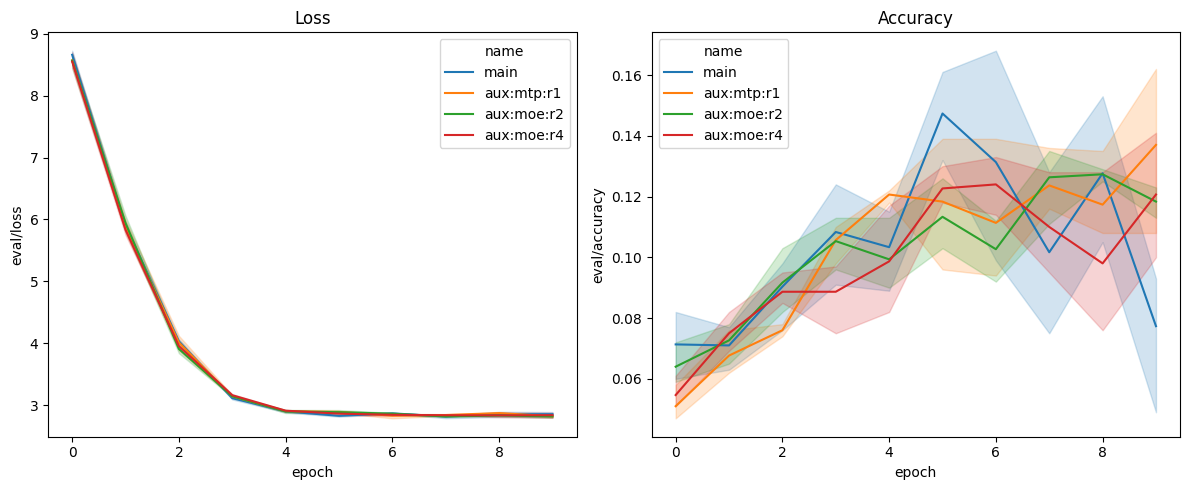

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd


dfs = []
for m in models:
    print(m['name'])
    df_i = pd.DataFrame({'epoch': range(len(m['eval/accuracy'])), 'eval/accuracy': m['eval/accuracy'], 'eval/loss': m['eval/loss'], 'name': m['name']})
    dfs.append(df_i)    
df = pd.concat(dfs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.lineplot(data=df, x="epoch", y="eval/loss", hue="name", ax=axes[0])
axes[0].set_title("Loss")

sns.lineplot(data=df, x="epoch", y="eval/accuracy", hue="name", ax=axes[1])
axes[1].set_title("Accuracy")

plt.tight_layout()
plt.show()
# save figure
plt.savefig(f'mtp_analysis.png')

# Comparison between CPJoint, CPCond and MoE

Two formualtions for modelling P(y1, ..., yH | x) using CP, we find the first to be unstable

1. Projecting $x$ onto CP parameter weights (bad)
2. Projectig $x$ onto MoE cores (bad)
3. Project x onto the MoE mixture weights

In [3]:
import torch
from mtp.mheads import MHEADS, AbstractDisributionHeadConfig


/Users/marawangamal/Documents/github/mtl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
class TrueModel:
    # P(y1, .., yH | x) (V^H x D)
    def __init__(self, d_model, d_vocab):
        super().__init__()
        self.d_model = d_model
        self.d_vocab = d_vocab



    def get_xy_samples(self, n_samples=1, horizon=1):
        """Sample x, y from p(x) and p(x,y1, y2, ..., yH | x)

        Args:
            n_samples (int, optional): Number of samples to draw from p(x). Defaults to 1.
            horizon (int, optional): Number of samples to draw from p(y1, y2, ..., yH | x). Defaults to 1.

        Returns:
            x: (n_samples, d_model)
            y: (n_samples, horizon)
        """
        x = torch.randn(n_samples, self.d_model)
        y = torch.randint(0, 2, (n_samples, horizon)) * (self.d_vocab - 1)
        return x, y



In [17]:
def train_model(model, gt_model, n_iterations=100, lr=1e-3, batch_size=128, device='cuda'):

    results = {
        "eval/loss": [],
        "grad_norm": [],
    }

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    model.train()
    for i in range(n_iterations):
        optimizer.zero_grad()
        x, y = gt_model.get_xy_samples(batch_size, model.config.horizon)  # (B, D) (B, H)
        x = x.to(device)
        y = y.to(device)
        
        output = model(x, y)
        loss = output.loss # (B,)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            # log gradient norm
            grad_norm = torch.linalg.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))
            results['grad_norm'].append(grad_norm.item())
            
            with torch.no_grad():
                x, y = gt_model.get_xy_samples(batch_size, model.config.horizon)  # (B, D) (B, H)
                x = x.to(device)
                y = y.to(device)
                output = model(x, y)
                loss = output.loss # (B,)
                results['eval/loss'].append(loss.mean().item())

    return results
           


In [41]:
# HPs
import itertools


lr = 1e-3
rank = 32
horizon = 4
d_model = 512
d_vocab = 100
n_iterations = 100
n_seeds = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

gt_model = TrueModel(d_model, d_vocab)

models = [
    {
        "mt_head": "moe",
        "model": {
            "rank": r,
            "horizon": h,
            "d_output": d_vocab
        },
    }
    for r, h in itertools.product([2, 4, 8], [2, 4, 8])
] + [
    {
        "mt_head": "cp",
        "model": {
            "rank": r,
            "horizon": h,
            "d_output": d_vocab
        },
    } for r, h in itertools.product([2, 4, 8], [2, 4, 8])
]

for model in models:
    m = MHEADS[model['mt_head']](
        config=AbstractDisributionHeadConfig(
            d_model=d_model, 
            d_output=d_vocab, 
            horizon=horizon, 
            rank=rank
        )
    )
    model['results']  = train_model(m, gt_model, n_iterations=n_iterations, device=device)



In [42]:
import pandas as pd


dfs = []
cols = [
    "eval/loss",
    "grad_norm",
]
for m in models:
    df_dict = {k: v for k, v in m['results'].items() if k in cols}
    df_dict['mt_head'] = m['mt_head']
    df_dict['epoch'] = range(len(df_dict[cols[0]]))
    df_i = pd.DataFrame(df_dict)
    dfs.append(df_i)    
df = pd.concat(dfs)

# Melt excluding mt_name from value columns
melt_df = df.melt(
    id_vars=["epoch", "mt_head"],
    var_name="metric",
    value_name="value",
)

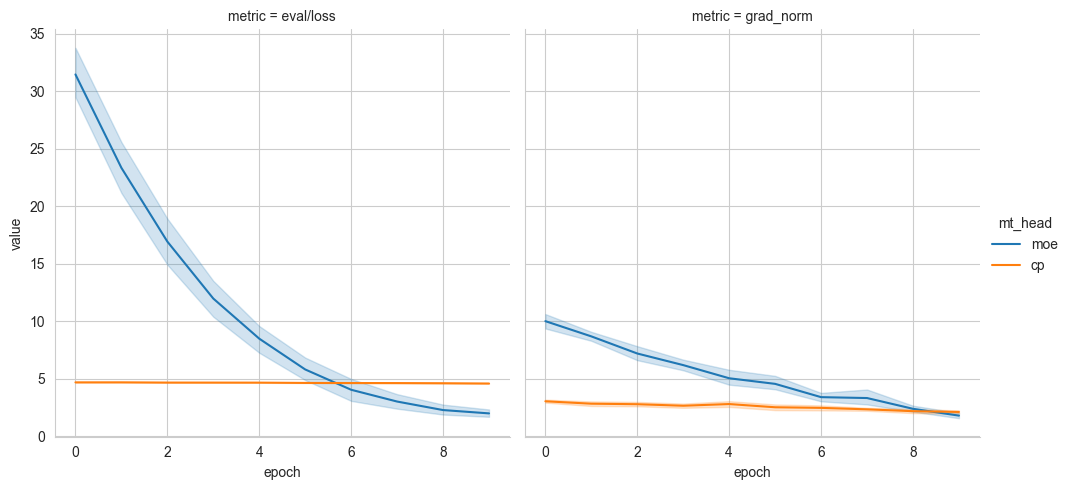

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

g = sns.relplot(
        data=melt_df,
        kind="line",
        x="epoch",
        y="value",
        hue="mt_head",
        col="metric",
)
# # set y-axis to logarithmic scale
# g.set(yscale="log")

plt.show()
